## Study of type event recognition for the PETALO experiment using ML

### Imports

In [1]:
import numpy  as np
import pandas as pd
import random

import matplotlib.pyplot as plt

In [2]:
#in terminal set the course conda env: conda activate machine-learning-course
from tensorflow.keras               import layers
from tensorflow.keras               import regularizers
from tensorflow.keras.utils         import to_categorical
from tensorflow.keras.models        import Sequential
from tensorflow.keras.layers        import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks     import ModelCheckpoint, EarlyStopping

### Loading data:

Code to select events and plotting utils in https://github.com/carmenromo/Analysis/tree/master/machine_learning_course

In [3]:
phot_list, compt_list = [], []
data_file  = '/Users/carmenromoluque/machine-learning-course/full_body_4cmd_images_phot_compt_and_phot_like.npz'
data       = np.load(data_file, allow_pickle=True)
for im in data['phot_images']:
    if len(im)==0:
        continue
    phot_list .append(im.reshape(400))
for im in data['compt_images']:
    if len(im)==0:
        continue
    compt_list.append(im.reshape(400))
for im in data['phot_like_images']:
    if len(im)==0:
        continue
    phot_list.append(im.reshape(400))

compt_images     = np.array(compt_list)
phot_images      = np.array(phot_list)

In [4]:
phot_images.shape

(44932, 400)

In [5]:
compt_images.shape

(25000, 400)

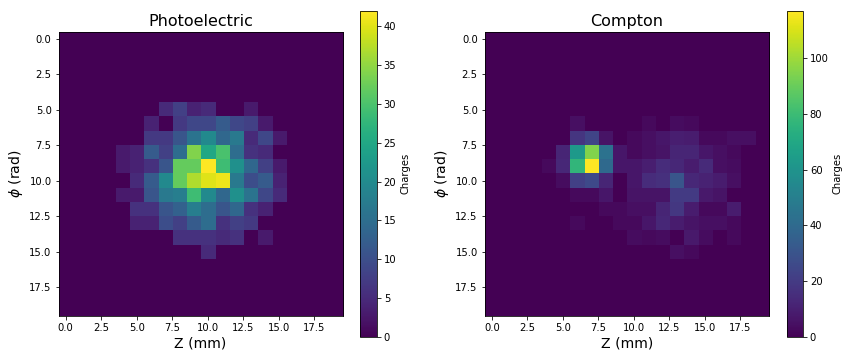

In [6]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(14,6))
fig1 = ax1.imshow( phot_images[4].reshape(20,20))
fig2 = ax2.imshow(compt_images[0].reshape(20,20))
ax1.set_xlabel('Z (mm)',       size=14)
ax1.set_ylabel('$\phi$ (rad)', size=14)
ax1.set_title('Photoelectric', size=16)
ax2.set_xlabel('Z (mm)',       size=14)
ax2.set_ylabel('$\phi$ (rad)', size=14)
ax2.set_title('Compton',       size=16)
fig.colorbar(fig1, ax=ax1, label='Charges')
fig.colorbar(fig2, ax=ax2, label='Charges')
plt.show()

In the previous plot I have chosen ideal images of photoelectric and compton (phot more compact and compton more sparse), because I found that the pattern in the sipms is pretty similar between these two kinds of events, that's why I would be so happy if the CNN manages to distinguish them successfully.

#### Create the labels:
- compton:       0
- photoelectric: 1

In [7]:
compt_labels = np.zeros(len(compt_images))
phot_labels  = np.ones (len( phot_images))

### Normalization:

In [8]:
norm_phot_images  = np.array([i/np.max(i) for i in  phot_images])
norm_compt_images = np.array([i/np.max(i) for i in compt_images])

## Inputs for the CNN:

In [9]:
y = np.concatenate((compt_labels,      phot_labels     ))
x = np.concatenate((norm_compt_images, norm_phot_images))
print(y.shape)
print(x.shape)
print(y)

(69932,)
(69932, 400)
[0. 0. 0. ... 1. 1. 1.]


We want to mix the images so that they are not in order (but labels in the same way too):

In [10]:
c = list(zip(x, y))
np.random.shuffle(c)
x, y = zip(*c)
y = np.array(y)
x = np.array(x).astype('float32') 

Split data in trining, validation and testing:

In [11]:
#######
train_split = 50000
#######
test_split  = 10000
#######

y_train = y[                 :train_split]
x_train = x[                 :train_split]
y_val   = y[train_split      :len(y)-test_split]
x_val   = x[train_split      :len(x)-test_split]
y_test  = y[len(y)-test_split:                 ]
x_test  = x[len(x)-test_split:                 ]

In [12]:
print(x_test .shape, y_test .shape)
print(x_train.shape, y_train.shape)
print(x_val  .shape, y_val  .shape)

(10000, 400) (10000,)
(50000, 400) (50000,)
(9932, 400) (9932,)


In [13]:
myset     = set(y_train)
mysettest = set(y_test)
print(myset)
print(mysettest)
print(y)

{0.0, 1.0}
{0.0, 1.0}
[1. 0. 1. ... 1. 1. 0.]


In [14]:
y_train_hot = to_categorical(y_train)
y_val_hot   = to_categorical(y_val)
y_test_hot  = to_categorical(y_test)

print(y_train_hot.shape)
print(y_val_hot  .shape)
print(y_test_hot .shape)

(50000, 2)
(9932, 2)
(10000, 2)


50000 train samples
9932 validation samples


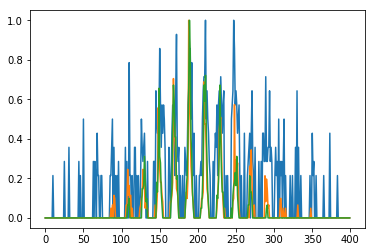

In [15]:
print(x_train.shape[0], 'train samples')
print(x_val.shape[0], 'validation samples')
plt.plot(x_train[0])
plt.plot(x_train[1])
plt.plot(x_test[0])
plt.show()

Reshape data for CNN:

In [16]:
x_train_cnn = x_train.reshape(-1, 20, 20, 1)
x_test_cnn  = x_test .reshape(-1, 20, 20, 1)
x_val_cnn   = x_val  .reshape(-1, 20, 20, 1)
x_train_cnn.shape

(50000, 20, 20, 1)

In [19]:
layer = layers.Dense(
    units=64,
    kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
    bias_regularizer=regularizers.l2(1e-4),
    activity_regularizer=regularizers.l2(1e-5)
)

# a fairly small network for speed
cnnmodel = Sequential()
#cnnmodel.add(Conv2D(128, (4, 4), activation='relu', input_shape=(20, 20, 1)))
cnnmodel.add(Conv2D(64, (2, 2), activation='relu', input_shape=(20, 20, 1))) #2D convolution layer
cnnmodel.add(MaxPooling2D((2, 2))) #Max pooling operation for 2D spatial data.
cnnmodel.add(layer)
cnnmodel.add(Dropout(0.4, input_shape=(20,20,1)))
cnnmodel.add(Conv2D(256, (4, 4), activation='relu'))
#cnnmodel.add(Conv2D(128, (3, 3), activation='relu'))
cnnmodel.add(MaxPooling2D((2, 2)))
cnnmodel.add(Dropout(0.1, input_shape=(20,20,1)))
cnnmodel.add(Flatten())
cnnmodel.add(Dense(2, activation='softmax'))

cnnmodel.compile(loss='categorical_crossentropy',
                optimizer='adam', #RMSprop(),
                metrics=['accuracy'])

cnnmodel.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 19, 19, 64)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 9, 64)          0         
_________________________________________________________________
dense_2 (Dense)              (None, 9, 9, 64)          4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 9, 9, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 6, 256)         262400    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 3, 3, 256)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 3, 3, 256)        

In [20]:
batch_size = 50
epochs     = 30

## To prevent it from memorizing the learning samples when the number of epochs is high

dir_path        = '/Users/carmenromoluque/machine-learning-course/'
best_model_name = dir_path + f'CNN_regression_R_{epochs}_{batch_size}.h5'
model_check     = ModelCheckpoint(best_model_name, monitor='val_sigma', verbose=1, save_best_only=True, 
                                  save_weights_only=False, mode='min', save_freq=1)
early_stop      = EarlyStopping(monitor='val_loss', min_delta=0, patience=900, 
                                verbose=1, mode='auto', baseline=None)


history = cnnmodel.fit(x_train_cnn, y_train_hot,
                       batch_size=batch_size, 
                       epochs=epochs,
                       verbose=1,
                       validation_data=(x_val_cnn, y_val_hot),
                       callbacks=[model_check, early_stop])

Train on 50000 samples, validate on 9932 samples
Epoch 1/30
 2350/50000 [>.............................] - ETA: 2:05 - loss: 0.6312 - accuracy: 0.6634WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 4750/50000 [=>............................] - ETA: 1:42 - loss: 0.6243 - accuracy: 0.6693WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 7150/50000 [===>..........................] - ETA: 1:31 - loss: 0.6201 - accuracy: 0.6710WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 9550/50000 [====>.........................] - ETA: 1:23 - loss: 0.6187 - accuracy: 0.6729WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


11950/50000 [======>.......................] - ETA: 1:16 - loss: 0.6177 - accuracy: 0.6724WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


14350/50000 [=======>......................] - ETA: 1:10 - loss: 0.6164 - accuracy: 0.6744WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


16750/50000 [=========>....................] - ETA: 1:06 - loss: 0.6152 - accuracy: 0.6768WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


19150/50000 [==========>...................] - ETA: 1:04 - loss: 0.6134 - accuracy: 0.6794WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


21550/50000 [===========>..................] - ETA: 1:00 - loss: 0.6114 - accuracy: 0.6825WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


23950/50000 [=============>................] - ETA: 55s - loss: 0.6119 - accuracy: 0.6823WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


26350/50000 [==============>...............] - ETA: 49s - loss: 0.6120 - accuracy: 0.6809WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


28750/50000 [================>.............] - ETA: 44s - loss: 0.6100 - accuracy: 0.6829WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


31150/50000 [=================>............] - ETA: 38s - loss: 0.6099 - accuracy: 0.6830WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


33550/50000 [===================>..........] - ETA: 33s - loss: 0.6092 - accuracy: 0.6836WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


35950/50000 [====================>.........] - ETA: 28s - loss: 0.6074 - accuracy: 0.6850WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


38350/50000 [======================>.......] - ETA: 23s - loss: 0.6068 - accuracy: 0.6854WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


40750/50000 [=======================>......] - ETA: 18s - loss: 0.6060 - accuracy: 0.6860WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


43150/50000 [========================>.....] - ETA: 13s - loss: 0.6060 - accuracy: 0.6860WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


45600/50000 [==========================>...] - ETA: 8s - loss: 0.6046 - accuracy: 0.6871WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


48050/50000 [===========================>..] - ETA: 3s - loss: 0.6044 - accuracy: 0.6873WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


50000/50000 [==============================] - 101s 2ms/sample - loss: 0.6034 - accuracy: 0.6883 - val_loss: 0.6012 - val_accuracy: 0.6940
Epoch 2/30
  450/50000 [..............................] - ETA: 1:33 - loss: 0.5977 - accuracy: 0.7089WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 2850/50000 [>.............................] - ETA: 1:28 - loss: 0.6010 - accuracy: 0.6860WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 5250/50000 [==>...........................] - ETA: 1:24 - loss: 0.5996 - accuracy: 0.6834WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 7650/50000 [===>..........................] - ETA: 1:19 - loss: 0.5950 - accuracy: 0.6869WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


10050/50000 [=====>........................] - ETA: 1:14 - loss: 0.5954 - accuracy: 0.6890WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


12450/50000 [======>.......................] - ETA: 1:09 - loss: 0.5973 - accuracy: 0.6884WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


14850/50000 [=======>......................] - ETA: 1:04 - loss: 0.5958 - accuracy: 0.6906WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


17250/50000 [=========>....................] - ETA: 1:00 - loss: 0.5955 - accuracy: 0.6903WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


19650/50000 [==========>...................] - ETA: 55s - loss: 0.5948 - accuracy: 0.6912WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


22050/50000 [============>.................] - ETA: 51s - loss: 0.5958 - accuracy: 0.6921WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


24450/50000 [=============>................] - ETA: 46s - loss: 0.5946 - accuracy: 0.6927WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


26850/50000 [===============>..............] - ETA: 42s - loss: 0.5947 - accuracy: 0.6930WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


29250/50000 [================>.............] - ETA: 37s - loss: 0.5945 - accuracy: 0.6930WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


31650/50000 [=================>............] - ETA: 33s - loss: 0.5944 - accuracy: 0.6933WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


34050/50000 [===================>..........] - ETA: 29s - loss: 0.5946 - accuracy: 0.6932WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


36450/50000 [====================>.........] - ETA: 24s - loss: 0.5949 - accuracy: 0.6931WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


38850/50000 [======================>.......] - ETA: 20s - loss: 0.5946 - accuracy: 0.6941WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


41250/50000 [=======================>......] - ETA: 15s - loss: 0.5947 - accuracy: 0.6945WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


43650/50000 [=========================>....] - ETA: 11s - loss: 0.5944 - accuracy: 0.6949WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


46100/50000 [==========================>...] - ETA: 7s - loss: 0.5943 - accuracy: 0.6948WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


48550/50000 [============================>.] - ETA: 2s - loss: 0.5934 - accuracy: 0.6954WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


50000/50000 [==============================] - 94s 2ms/sample - loss: 0.5941 - accuracy: 0.6949 - val_loss: 0.6011 - val_accuracy: 0.6981
Epoch 3/30
  950/50000 [..............................] - ETA: 1:28 - loss: 0.6071 - accuracy: 0.6758WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 3350/50000 [=>............................] - ETA: 1:24 - loss: 0.5987 - accuracy: 0.6937WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 5750/50000 [==>...........................] - ETA: 1:20 - loss: 0.5968 - accuracy: 0.6948WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 8150/50000 [===>..........................] - ETA: 1:15 - loss: 0.5954 - accuracy: 0.6952WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


10550/50000 [=====>........................] - ETA: 1:11 - loss: 0.5899 - accuracy: 0.6985WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


12950/50000 [======>.......................] - ETA: 1:07 - loss: 0.5903 - accuracy: 0.6971WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


15350/50000 [========>.....................] - ETA: 1:10 - loss: 0.5911 - accuracy: 0.6972WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


17750/50000 [=========>....................] - ETA: 1:03 - loss: 0.5916 - accuracy: 0.6963WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


20150/50000 [===========>..................] - ETA: 57s - loss: 0.5920 - accuracy: 0.6963WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


22550/50000 [============>.................] - ETA: 51s - loss: 0.5925 - accuracy: 0.6952WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


24950/50000 [=============>................] - ETA: 46s - loss: 0.5917 - accuracy: 0.6965WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


27350/50000 [===============>..............] - ETA: 40s - loss: 0.5921 - accuracy: 0.6963WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


29750/50000 [================>.............] - ETA: 36s - loss: 0.5916 - accuracy: 0.6964WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


32150/50000 [==================>...........] - ETA: 31s - loss: 0.5917 - accuracy: 0.6966WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


34550/50000 [===================>..........] - ETA: 27s - loss: 0.5911 - accuracy: 0.6972WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


36950/50000 [=====================>........] - ETA: 23s - loss: 0.5914 - accuracy: 0.6974WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


39350/50000 [======================>.......] - ETA: 18s - loss: 0.5906 - accuracy: 0.6978WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


41750/50000 [========================>.....] - ETA: 14s - loss: 0.5899 - accuracy: 0.6985WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


44150/50000 [=========================>....] - ETA: 10s - loss: 0.5902 - accuracy: 0.6982WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


46600/50000 [==========================>...] - ETA: 6s - loss: 0.5901 - accuracy: 0.6983WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


49050/50000 [============================>.] - ETA: 1s - loss: 0.5900 - accuracy: 0.6982WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


50000/50000 [==============================] - 91s 2ms/sample - loss: 0.5897 - accuracy: 0.6984 - val_loss: 0.5954 - val_accuracy: 0.6968
Epoch 4/30
 1450/50000 [..............................] - ETA: 1:19 - loss: 0.5901 - accuracy: 0.7034WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 3850/50000 [=>............................] - ETA: 1:35 - loss: 0.5860 - accuracy: 0.7008WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 6250/50000 [==>...........................] - ETA: 1:27 - loss: 0.5899 - accuracy: 0.6960WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 8650/50000 [====>.........................] - ETA: 1:18 - loss: 0.5893 - accuracy: 0.6955WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


11050/50000 [=====>........................] - ETA: 1:12 - loss: 0.5871 - accuracy: 0.6966WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


13450/50000 [=======>......................] - ETA: 1:06 - loss: 0.5853 - accuracy: 0.7003WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


15850/50000 [========>.....................] - ETA: 1:01 - loss: 0.5829 - accuracy: 0.7023WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


18250/50000 [=========>....................] - ETA: 56s - loss: 0.5838 - accuracy: 0.7014WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


20650/50000 [===========>..................] - ETA: 51s - loss: 0.5848 - accuracy: 0.6995WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


23050/50000 [============>.................] - ETA: 47s - loss: 0.5852 - accuracy: 0.7003WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


25450/50000 [==============>...............] - ETA: 42s - loss: 0.5855 - accuracy: 0.7009WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


27850/50000 [===============>..............] - ETA: 38s - loss: 0.5866 - accuracy: 0.7000WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


30250/50000 [=================>............] - ETA: 34s - loss: 0.5870 - accuracy: 0.6995WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


32650/50000 [==================>...........] - ETA: 29s - loss: 0.5869 - accuracy: 0.6995WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


35050/50000 [====================>.........] - ETA: 25s - loss: 0.5870 - accuracy: 0.6998WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


37450/50000 [=====================>........] - ETA: 21s - loss: 0.5864 - accuracy: 0.7006WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


39850/50000 [======================>.......] - ETA: 17s - loss: 0.5864 - accuracy: 0.7003WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


42250/50000 [========================>.....] - ETA: 13s - loss: 0.5866 - accuracy: 0.6998WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


44700/50000 [=========================>....] - ETA: 9s - loss: 0.5869 - accuracy: 0.6999WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


47150/50000 [===========================>..] - ETA: 4s - loss: 0.5870 - accuracy: 0.7001WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


49600/50000 [============================>.] - ETA: 0s - loss: 0.5867 - accuracy: 0.7004WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


50000/50000 [==============================] - 88s 2ms/sample - loss: 0.5865 - accuracy: 0.7006 - val_loss: 0.5965 - val_accuracy: 0.6974
Epoch 5/30
 2000/50000 [>.............................] - ETA: 1:52 - loss: 0.5770 - accuracy: 0.7035WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 4400/50000 [=>............................] - ETA: 2:03 - loss: 0.5861 - accuracy: 0.6968WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 6800/50000 [===>..........................] - ETA: 1:38 - loss: 0.5868 - accuracy: 0.6956WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 9200/50000 [====>.........................] - ETA: 1:25 - loss: 0.5865 - accuracy: 0.6952WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


11600/50000 [=====>........................] - ETA: 1:16 - loss: 0.5810 - accuracy: 0.7006WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


14000/50000 [=======>......................] - ETA: 1:08 - loss: 0.5824 - accuracy: 0.7013WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


16400/50000 [========>.....................] - ETA: 1:02 - loss: 0.5848 - accuracy: 0.6987WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


18800/50000 [==========>...................] - ETA: 58s - loss: 0.5849 - accuracy: 0.6982WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


21200/50000 [===========>..................] - ETA: 55s - loss: 0.5842 - accuracy: 0.6995WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


23600/50000 [=============>................] - ETA: 51s - loss: 0.5835 - accuracy: 0.7004WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


26000/50000 [==============>...............] - ETA: 46s - loss: 0.5830 - accuracy: 0.7007WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


28400/50000 [================>.............] - ETA: 41s - loss: 0.5842 - accuracy: 0.7001WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


30800/50000 [=================>............] - ETA: 35s - loss: 0.5832 - accuracy: 0.7012WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


33200/50000 [==================>...........] - ETA: 30s - loss: 0.5822 - accuracy: 0.7023WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


35600/50000 [====================>.........] - ETA: 26s - loss: 0.5823 - accuracy: 0.7023WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


38000/50000 [=====================>........] - ETA: 21s - loss: 0.5823 - accuracy: 0.7027WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


40400/50000 [=======================>......] - ETA: 17s - loss: 0.5833 - accuracy: 0.7018WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


42800/50000 [========================>.....] - ETA: 12s - loss: 0.5831 - accuracy: 0.7017WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


45250/50000 [==========================>...] - ETA: 8s - loss: 0.5836 - accuracy: 0.7016WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


47700/50000 [===========================>..] - ETA: 3s - loss: 0.5845 - accuracy: 0.7007WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


50000/50000 [==============================] - 88s 2ms/sample - loss: 0.5838 - accuracy: 0.7013 - val_loss: 0.5949 - val_accuracy: 0.6974
Epoch 6/30
  100/50000 [..............................] - ETA: 1:13 - loss: 0.6010 - accuracy: 0.7000WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 2500/50000 [>.............................] - ETA: 1:12 - loss: 0.5822 - accuracy: 0.7020WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 4900/50000 [=>............................] - ETA: 1:07 - loss: 0.5770 - accuracy: 0.7076WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 7300/50000 [===>..........................] - ETA: 1:03 - loss: 0.5754 - accuracy: 0.7099WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 9700/50000 [====>.........................] - ETA: 59s - loss: 0.5771 - accuracy: 0.7073WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


12100/50000 [======>.......................] - ETA: 56s - loss: 0.5787 - accuracy: 0.7070WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


14500/50000 [=======>......................] - ETA: 52s - loss: 0.5786 - accuracy: 0.7074WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


16900/50000 [=========>....................] - ETA: 49s - loss: 0.5808 - accuracy: 0.7055WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


19300/50000 [==========>...................] - ETA: 45s - loss: 0.5801 - accuracy: 0.7059WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


21700/50000 [============>.................] - ETA: 42s - loss: 0.5787 - accuracy: 0.7060WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


24100/50000 [=============>................] - ETA: 38s - loss: 0.5796 - accuracy: 0.7054WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


26500/50000 [==============>...............] - ETA: 34s - loss: 0.5797 - accuracy: 0.7049WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


28900/50000 [================>.............] - ETA: 31s - loss: 0.5794 - accuracy: 0.7052WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


31300/50000 [=================>............] - ETA: 27s - loss: 0.5792 - accuracy: 0.7051WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


33700/50000 [===================>..........] - ETA: 24s - loss: 0.5789 - accuracy: 0.7050WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


36100/50000 [====================>.........] - ETA: 20s - loss: 0.5791 - accuracy: 0.7050WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


38500/50000 [======================>.......] - ETA: 17s - loss: 0.5787 - accuracy: 0.7058WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


40900/50000 [=======================>......] - ETA: 13s - loss: 0.5782 - accuracy: 0.7061WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


43300/50000 [========================>.....] - ETA: 9s - loss: 0.5792 - accuracy: 0.7051WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


45750/50000 [==========================>...] - ETA: 6s - loss: 0.5796 - accuracy: 0.7047WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


48200/50000 [===========================>..] - ETA: 2s - loss: 0.5808 - accuracy: 0.7034WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


50000/50000 [==============================] - 77s 2ms/sample - loss: 0.5810 - accuracy: 0.7031 - val_loss: 0.5920 - val_accuracy: 0.6961
Epoch 7/30
  600/50000 [..............................] - ETA: 1:09 - loss: 0.5756 - accuracy: 0.7000WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 3000/50000 [>.............................] - ETA: 1:09 - loss: 0.5747 - accuracy: 0.7077WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 5400/50000 [==>...........................] - ETA: 1:06 - loss: 0.5777 - accuracy: 0.7026WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 7800/50000 [===>..........................] - ETA: 1:04 - loss: 0.5731 - accuracy: 0.7081WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


10200/50000 [=====>........................] - ETA: 1:00 - loss: 0.5752 - accuracy: 0.7085WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


12600/50000 [======>.......................] - ETA: 56s - loss: 0.5765 - accuracy: 0.7087WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


15000/50000 [========>.....................] - ETA: 53s - loss: 0.5796 - accuracy: 0.7057WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


17400/50000 [=========>....................] - ETA: 49s - loss: 0.5801 - accuracy: 0.7045WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


19800/50000 [==========>...................] - ETA: 45s - loss: 0.5807 - accuracy: 0.7032WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


22200/50000 [============>.................] - ETA: 42s - loss: 0.5802 - accuracy: 0.7033WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


24600/50000 [=============>................] - ETA: 38s - loss: 0.5796 - accuracy: 0.7037WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


27000/50000 [===============>..............] - ETA: 34s - loss: 0.5801 - accuracy: 0.7030WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


29400/50000 [================>.............] - ETA: 31s - loss: 0.5785 - accuracy: 0.7040WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


31800/50000 [==================>...........] - ETA: 27s - loss: 0.5789 - accuracy: 0.7032WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


34200/50000 [===================>..........] - ETA: 24s - loss: 0.5787 - accuracy: 0.7036WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


36600/50000 [====================>.........] - ETA: 20s - loss: 0.5788 - accuracy: 0.7043WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


39000/50000 [======================>.......] - ETA: 16s - loss: 0.5791 - accuracy: 0.7042WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


41400/50000 [=======================>......] - ETA: 13s - loss: 0.5794 - accuracy: 0.7037WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


43800/50000 [=========================>....] - ETA: 9s - loss: 0.5793 - accuracy: 0.7039WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


46250/50000 [==========================>...] - ETA: 5s - loss: 0.5791 - accuracy: 0.7041WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


48700/50000 [============================>.] - ETA: 2s - loss: 0.5792 - accuracy: 0.7039WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


50000/50000 [==============================] - 80s 2ms/sample - loss: 0.5787 - accuracy: 0.7045 - val_loss: 0.5912 - val_accuracy: 0.7022
Epoch 8/30
 1100/50000 [..............................] - ETA: 1:11 - loss: 0.5874 - accuracy: 0.6891WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 3500/50000 [=>............................] - ETA: 1:08 - loss: 0.5759 - accuracy: 0.7060WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 5900/50000 [==>...........................] - ETA: 1:05 - loss: 0.5788 - accuracy: 0.7007WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 8300/50000 [===>..........................] - ETA: 1:01 - loss: 0.5770 - accuracy: 0.7039WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


10700/50000 [=====>........................] - ETA: 58s - loss: 0.5745 - accuracy: 0.7055WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


13100/50000 [======>.......................] - ETA: 54s - loss: 0.5759 - accuracy: 0.7042WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


15500/50000 [========>.....................] - ETA: 51s - loss: 0.5738 - accuracy: 0.7066WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


17900/50000 [=========>....................] - ETA: 47s - loss: 0.5767 - accuracy: 0.7036WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


20300/50000 [===========>..................] - ETA: 44s - loss: 0.5769 - accuracy: 0.7041WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


22700/50000 [============>.................] - ETA: 40s - loss: 0.5773 - accuracy: 0.7031WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


25100/50000 [==============>...............] - ETA: 37s - loss: 0.5788 - accuracy: 0.7017WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


27500/50000 [===============>..............] - ETA: 33s - loss: 0.5786 - accuracy: 0.7019WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


29900/50000 [================>.............] - ETA: 30s - loss: 0.5784 - accuracy: 0.7016WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


32300/50000 [==================>...........] - ETA: 26s - loss: 0.5780 - accuracy: 0.7022WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


34700/50000 [===================>..........] - ETA: 22s - loss: 0.5783 - accuracy: 0.7022WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


37100/50000 [=====================>........] - ETA: 19s - loss: 0.5791 - accuracy: 0.7018WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


39500/50000 [======================>.......] - ETA: 15s - loss: 0.5779 - accuracy: 0.7032WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


41900/50000 [========================>.....] - ETA: 12s - loss: 0.5770 - accuracy: 0.7041WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


44350/50000 [=========================>....] - ETA: 8s - loss: 0.5765 - accuracy: 0.7044WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


46800/50000 [===========================>..] - ETA: 5s - loss: 0.5771 - accuracy: 0.7042WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


49250/50000 [============================>.] - ETA: 1s - loss: 0.5767 - accuracy: 0.7047WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


50000/50000 [==============================] - 86s 2ms/sample - loss: 0.5770 - accuracy: 0.7044 - val_loss: 0.5896 - val_accuracy: 0.7019
Epoch 9/30
 1650/50000 [..............................] - ETA: 1:48 - loss: 0.5754 - accuracy: 0.7036WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 4050/50000 [=>............................] - ETA: 1:25 - loss: 0.5693 - accuracy: 0.7104WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 6450/50000 [==>...........................] - ETA: 1:15 - loss: 0.5652 - accuracy: 0.7119WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 8850/50000 [====>.........................] - ETA: 1:08 - loss: 0.5682 - accuracy: 0.7073WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


11250/50000 [=====>........................] - ETA: 1:03 - loss: 0.5672 - accuracy: 0.7084WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


13650/50000 [=======>......................] - ETA: 59s - loss: 0.5703 - accuracy: 0.7050WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


16050/50000 [========>.....................] - ETA: 55s - loss: 0.5697 - accuracy: 0.7066WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


18450/50000 [==========>...................] - ETA: 50s - loss: 0.5716 - accuracy: 0.7053WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


20850/50000 [===========>..................] - ETA: 46s - loss: 0.5727 - accuracy: 0.7035WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


23250/50000 [============>.................] - ETA: 42s - loss: 0.5733 - accuracy: 0.7050WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


25650/50000 [==============>...............] - ETA: 38s - loss: 0.5739 - accuracy: 0.7041WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


28050/50000 [===============>..............] - ETA: 34s - loss: 0.5758 - accuracy: 0.7029WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


30450/50000 [=================>............] - ETA: 31s - loss: 0.5765 - accuracy: 0.7030WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


32850/50000 [==================>...........] - ETA: 27s - loss: 0.5764 - accuracy: 0.7033WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


35250/50000 [====================>.........] - ETA: 23s - loss: 0.5757 - accuracy: 0.7041WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


37650/50000 [=====================>........] - ETA: 19s - loss: 0.5746 - accuracy: 0.7044WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


40050/50000 [=======================>......] - ETA: 15s - loss: 0.5750 - accuracy: 0.7043WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


42450/50000 [========================>.....] - ETA: 11s - loss: 0.5754 - accuracy: 0.7042WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


44900/50000 [=========================>....] - ETA: 7s - loss: 0.5755 - accuracy: 0.7041WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


47350/50000 [===========================>..] - ETA: 4s - loss: 0.5752 - accuracy: 0.7046WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


49800/50000 [============================>.] - ETA: 0s - loss: 0.5747 - accuracy: 0.7051WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


50000/50000 [==============================] - 81s 2ms/sample - loss: 0.5746 - accuracy: 0.7051 - val_loss: 0.5918 - val_accuracy: 0.7003
Epoch 10/30
 2200/50000 [>.............................] - ETA: 1:19 - loss: 0.5663 - accuracy: 0.7100WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 4600/50000 [=>............................] - ETA: 1:12 - loss: 0.5622 - accuracy: 0.7159WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 7000/50000 [===>..........................] - ETA: 1:10 - loss: 0.5612 - accuracy: 0.7197WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 9400/50000 [====>.........................] - ETA: 1:05 - loss: 0.5642 - accuracy: 0.7181WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


11800/50000 [======>.......................] - ETA: 1:01 - loss: 0.5671 - accuracy: 0.7129WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


14200/50000 [=======>......................] - ETA: 57s - loss: 0.5698 - accuracy: 0.7115WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


16600/50000 [========>.....................] - ETA: 53s - loss: 0.5694 - accuracy: 0.7117WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


19000/50000 [==========>...................] - ETA: 49s - loss: 0.5696 - accuracy: 0.7113WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


21400/50000 [===========>..................] - ETA: 45s - loss: 0.5697 - accuracy: 0.7111WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


23800/50000 [=============>................] - ETA: 41s - loss: 0.5692 - accuracy: 0.7118WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


26200/50000 [==============>...............] - ETA: 37s - loss: 0.5698 - accuracy: 0.7114WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


28600/50000 [================>.............] - ETA: 33s - loss: 0.5700 - accuracy: 0.7109WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


31000/50000 [=================>............] - ETA: 30s - loss: 0.5703 - accuracy: 0.7103WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


33400/50000 [===================>..........] - ETA: 26s - loss: 0.5694 - accuracy: 0.7114WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


35800/50000 [====================>.........] - ETA: 22s - loss: 0.5692 - accuracy: 0.7110WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


38200/50000 [=====================>........] - ETA: 18s - loss: 0.5690 - accuracy: 0.7110WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


40600/50000 [=======================>......] - ETA: 14s - loss: 0.5694 - accuracy: 0.7106WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


43000/50000 [========================>.....] - ETA: 10s - loss: 0.5701 - accuracy: 0.7097WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


45450/50000 [==========================>...] - ETA: 7s - loss: 0.5705 - accuracy: 0.7085WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


47900/50000 [===========================>..] - ETA: 3s - loss: 0.5721 - accuracy: 0.7074WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


50000/50000 [==============================] - 81s 2ms/sample - loss: 0.5720 - accuracy: 0.7075 - val_loss: 0.5922 - val_accuracy: 0.7021
Epoch 11/30
  300/50000 [..............................] - ETA: 1:44 - loss: 0.5793 - accuracy: 0.7133WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 2700/50000 [>.............................] - ETA: 1:32 - loss: 0.5785 - accuracy: 0.6963WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 5100/50000 [==>...........................] - ETA: 1:21 - loss: 0.5744 - accuracy: 0.7012WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 7500/50000 [===>..........................] - ETA: 1:13 - loss: 0.5685 - accuracy: 0.7083WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 9900/50000 [====>.........................] - ETA: 1:09 - loss: 0.5677 - accuracy: 0.7075WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


12300/50000 [======>.......................] - ETA: 1:04 - loss: 0.5670 - accuracy: 0.7080WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


14700/50000 [=======>......................] - ETA: 1:00 - loss: 0.5673 - accuracy: 0.7088WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


17100/50000 [=========>....................] - ETA: 56s - loss: 0.5676 - accuracy: 0.7094WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


19500/50000 [==========>...................] - ETA: 51s - loss: 0.5686 - accuracy: 0.7083WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


21900/50000 [============>.................] - ETA: 47s - loss: 0.5697 - accuracy: 0.7070WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


24300/50000 [=============>................] - ETA: 42s - loss: 0.5701 - accuracy: 0.7075WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


26700/50000 [===============>..............] - ETA: 38s - loss: 0.5698 - accuracy: 0.7078WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


29100/50000 [================>.............] - ETA: 34s - loss: 0.5711 - accuracy: 0.7062WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


31500/50000 [=================>............] - ETA: 31s - loss: 0.5724 - accuracy: 0.7050WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


33900/50000 [===================>..........] - ETA: 27s - loss: 0.5709 - accuracy: 0.7065WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


36300/50000 [====================>.........] - ETA: 23s - loss: 0.5706 - accuracy: 0.7066WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


38700/50000 [======================>.......] - ETA: 19s - loss: 0.5703 - accuracy: 0.7071WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


41100/50000 [=======================>......] - ETA: 15s - loss: 0.5697 - accuracy: 0.7078WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


43500/50000 [=========================>....] - ETA: 11s - loss: 0.5700 - accuracy: 0.7077WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


45950/50000 [==========================>...] - ETA: 6s - loss: 0.5698 - accuracy: 0.7079WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


48400/50000 [============================>.] - ETA: 2s - loss: 0.5693 - accuracy: 0.7081WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


50000/50000 [==============================] - 88s 2ms/sample - loss: 0.5689 - accuracy: 0.7084 - val_loss: 0.5924 - val_accuracy: 0.6968
Epoch 12/30
  800/50000 [..............................] - ETA: 1:13 - loss: 0.5580 - accuracy: 0.7113WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 3200/50000 [>.............................] - ETA: 1:11 - loss: 0.5561 - accuracy: 0.7109WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 5600/50000 [==>...........................] - ETA: 1:07 - loss: 0.5620 - accuracy: 0.7084WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 8000/50000 [===>..........................] - ETA: 1:03 - loss: 0.5634 - accuracy: 0.7074WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


10400/50000 [=====>........................] - ETA: 59s - loss: 0.5617 - accuracy: 0.7105WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


12800/50000 [======>.......................] - ETA: 55s - loss: 0.5605 - accuracy: 0.7100WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


15200/50000 [========>.....................] - ETA: 52s - loss: 0.5601 - accuracy: 0.7097WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


17600/50000 [=========>....................] - ETA: 51s - loss: 0.5614 - accuracy: 0.7090WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


20000/50000 [===========>..................] - ETA: 48s - loss: 0.5623 - accuracy: 0.7075WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


22400/50000 [============>.................] - ETA: 44s - loss: 0.5631 - accuracy: 0.7075WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


24800/50000 [=============>................] - ETA: 40s - loss: 0.5639 - accuracy: 0.7078WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


27200/50000 [===============>..............] - ETA: 36s - loss: 0.5638 - accuracy: 0.7093WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


29600/50000 [================>.............] - ETA: 32s - loss: 0.5654 - accuracy: 0.7082WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


32000/50000 [==================>...........] - ETA: 28s - loss: 0.5657 - accuracy: 0.7077WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


34400/50000 [===================>..........] - ETA: 24s - loss: 0.5660 - accuracy: 0.7083WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


36800/50000 [=====================>........] - ETA: 20s - loss: 0.5647 - accuracy: 0.7096WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


39200/50000 [======================>.......] - ETA: 16s - loss: 0.5649 - accuracy: 0.7091WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


41600/50000 [=======================>......] - ETA: 13s - loss: 0.5651 - accuracy: 0.7090WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


44050/50000 [=========================>....] - ETA: 9s - loss: 0.5645 - accuracy: 0.7092WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


46500/50000 [==========================>...] - ETA: 5s - loss: 0.5641 - accuracy: 0.7092WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


48950/50000 [============================>.] - ETA: 1s - loss: 0.5644 - accuracy: 0.7090WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


50000/50000 [==============================] - 80s 2ms/sample - loss: 0.5645 - accuracy: 0.7090 - val_loss: 0.5954 - val_accuracy: 0.6964
Epoch 13/30
 1350/50000 [..............................] - ETA: 1:10 - loss: 0.5418 - accuracy: 0.7400WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 3750/50000 [=>............................] - ETA: 1:06 - loss: 0.5524 - accuracy: 0.7197WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 6150/50000 [==>...........................] - ETA: 1:03 - loss: 0.5542 - accuracy: 0.7130WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 8550/50000 [====>.........................] - ETA: 1:00 - loss: 0.5580 - accuracy: 0.7091WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


10950/50000 [=====>........................] - ETA: 56s - loss: 0.5603 - accuracy: 0.7089WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


13350/50000 [=======>......................] - ETA: 53s - loss: 0.5602 - accuracy: 0.7085WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


15750/50000 [========>.....................] - ETA: 50s - loss: 0.5608 - accuracy: 0.7069WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


18150/50000 [=========>....................] - ETA: 46s - loss: 0.5618 - accuracy: 0.7070WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


20550/50000 [===========>..................] - ETA: 43s - loss: 0.5617 - accuracy: 0.7074WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


22950/50000 [============>.................] - ETA: 39s - loss: 0.5630 - accuracy: 0.7063WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


25350/50000 [==============>...............] - ETA: 36s - loss: 0.5626 - accuracy: 0.7067WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


27750/50000 [===============>..............] - ETA: 32s - loss: 0.5624 - accuracy: 0.7063WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


30150/50000 [=================>............] - ETA: 29s - loss: 0.5621 - accuracy: 0.7073WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


32550/50000 [==================>...........] - ETA: 25s - loss: 0.5632 - accuracy: 0.7070WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


34950/50000 [===================>..........] - ETA: 22s - loss: 0.5613 - accuracy: 0.7088WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


37350/50000 [=====================>........] - ETA: 18s - loss: 0.5615 - accuracy: 0.7089WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


39750/50000 [======================>.......] - ETA: 15s - loss: 0.5612 - accuracy: 0.7100WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


42150/50000 [========================>.....] - ETA: 11s - loss: 0.5617 - accuracy: 0.7094WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


44600/50000 [=========================>....] - ETA: 7s - loss: 0.5617 - accuracy: 0.7098WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


47050/50000 [===========================>..] - ETA: 4s - loss: 0.5609 - accuracy: 0.7109WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


49500/50000 [============================>.] - ETA: 0s - loss: 0.5608 - accuracy: 0.7113WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


50000/50000 [==============================] - 76s 2ms/sample - loss: 0.5610 - accuracy: 0.7112 - val_loss: 0.5994 - val_accuracy: 0.6995
Epoch 14/30
 1900/50000 [>.............................] - ETA: 1:11 - loss: 0.5490 - accuracy: 0.7163WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 4300/50000 [=>............................] - ETA: 1:07 - loss: 0.5559 - accuracy: 0.7112WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 6700/50000 [===>..........................] - ETA: 1:03 - loss: 0.5552 - accuracy: 0.7099WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 9100/50000 [====>.........................] - ETA: 1:00 - loss: 0.5537 - accuracy: 0.7121WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


11500/50000 [=====>........................] - ETA: 57s - loss: 0.5522 - accuracy: 0.7135WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


13900/50000 [=======>......................] - ETA: 53s - loss: 0.5549 - accuracy: 0.7140WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


16300/50000 [========>.....................] - ETA: 50s - loss: 0.5530 - accuracy: 0.7155WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


18700/50000 [==========>...................] - ETA: 47s - loss: 0.5525 - accuracy: 0.7150WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


21100/50000 [===========>..................] - ETA: 43s - loss: 0.5532 - accuracy: 0.7145WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


23500/50000 [=============>................] - ETA: 39s - loss: 0.5538 - accuracy: 0.7137WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


25900/50000 [==============>...............] - ETA: 36s - loss: 0.5536 - accuracy: 0.7145WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


28300/50000 [===============>..............] - ETA: 32s - loss: 0.5540 - accuracy: 0.7141WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


30700/50000 [=================>............] - ETA: 29s - loss: 0.5546 - accuracy: 0.7142WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


33100/50000 [==================>...........] - ETA: 25s - loss: 0.5554 - accuracy: 0.7141WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


35500/50000 [====================>.........] - ETA: 21s - loss: 0.5563 - accuracy: 0.7128WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


37900/50000 [=====================>........] - ETA: 18s - loss: 0.5558 - accuracy: 0.7133WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


40300/50000 [=======================>......] - ETA: 14s - loss: 0.5561 - accuracy: 0.7134WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


42700/50000 [========================>.....] - ETA: 10s - loss: 0.5561 - accuracy: 0.7135WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


45150/50000 [==========================>...] - ETA: 7s - loss: 0.5566 - accuracy: 0.7132WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


47600/50000 [===========================>..] - ETA: 3s - loss: 0.5567 - accuracy: 0.7131WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


50000/50000 [==============================] - 78s 2ms/sample - loss: 0.5571 - accuracy: 0.7133 - val_loss: 0.6013 - val_accuracy: 0.7063
Epoch 15/30


 2400/50000 [>.............................] - ETA: 1:19 - loss: 0.5618 - accuracy: 0.7100WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 4800/50000 [=>............................] - ETA: 1:12 - loss: 0.5587 - accuracy: 0.7081WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 7200/50000 [===>..........................] - ETA: 1:07 - loss: 0.5601 - accuracy: 0.7060WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 9600/50000 [====>.........................] - ETA: 1:03 - loss: 0.5563 - accuracy: 0.7103WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


12000/50000 [======>.......................] - ETA: 59s - loss: 0.5547 - accuracy: 0.7103WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


14400/50000 [=======>......................] - ETA: 54s - loss: 0.5509 - accuracy: 0.7130WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


16800/50000 [=========>....................] - ETA: 50s - loss: 0.5495 - accuracy: 0.7135WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


19200/50000 [==========>...................] - ETA: 47s - loss: 0.5507 - accuracy: 0.7134WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


21600/50000 [===========>..................] - ETA: 44s - loss: 0.5519 - accuracy: 0.7121WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


24000/50000 [=============>................] - ETA: 40s - loss: 0.5524 - accuracy: 0.7120WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


26400/50000 [==============>...............] - ETA: 36s - loss: 0.5519 - accuracy: 0.7123WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


28800/50000 [================>.............] - ETA: 33s - loss: 0.5517 - accuracy: 0.7130WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


31200/50000 [=================>............] - ETA: 29s - loss: 0.5524 - accuracy: 0.7124WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


33600/50000 [===================>..........] - ETA: 25s - loss: 0.5529 - accuracy: 0.7117WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


36000/50000 [====================>.........] - ETA: 22s - loss: 0.5523 - accuracy: 0.7126WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


38400/50000 [======================>.......] - ETA: 18s - loss: 0.5521 - accuracy: 0.7133WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


40800/50000 [=======================>......] - ETA: 14s - loss: 0.5525 - accuracy: 0.7126WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


43200/50000 [========================>.....] - ETA: 10s - loss: 0.5516 - accuracy: 0.7136WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


45650/50000 [==========================>...] - ETA: 6s - loss: 0.5513 - accuracy: 0.7139WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


48100/50000 [===========================>..] - ETA: 2s - loss: 0.5515 - accuracy: 0.7140WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


50000/50000 [==============================] - 81s 2ms/sample - loss: 0.5520 - accuracy: 0.7135 - val_loss: 0.6018 - val_accuracy: 0.7024
Epoch 16/30
  500/50000 [..............................] - ETA: 1:08 - loss: 0.5388 - accuracy: 0.7080WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 2900/50000 [>.............................] - ETA: 1:07 - loss: 0.5564 - accuracy: 0.7138WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 5300/50000 [==>...........................] - ETA: 1:03 - loss: 0.5525 - accuracy: 0.7115WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 7700/50000 [===>..........................] - ETA: 1:00 - loss: 0.5545 - accuracy: 0.7081WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


10100/50000 [=====>........................] - ETA: 57s - loss: 0.5515 - accuracy: 0.7104WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


12500/50000 [======>.......................] - ETA: 59s - loss: 0.5522 - accuracy: 0.7104WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


14900/50000 [=======>......................] - ETA: 1:00 - loss: 0.5508 - accuracy: 0.7132WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


17300/50000 [=========>....................] - ETA: 56s - loss: 0.5513 - accuracy: 0.7129WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


19700/50000 [==========>...................] - ETA: 51s - loss: 0.5502 - accuracy: 0.7150WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


22100/50000 [============>.................] - ETA: 46s - loss: 0.5484 - accuracy: 0.7159WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


24500/50000 [=============>................] - ETA: 42s - loss: 0.5494 - accuracy: 0.7147WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


26900/50000 [===============>..............] - ETA: 38s - loss: 0.5495 - accuracy: 0.7148WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


29300/50000 [================>.............] - ETA: 33s - loss: 0.5487 - accuracy: 0.7151WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


31700/50000 [==================>...........] - ETA: 29s - loss: 0.5476 - accuracy: 0.7163WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


34100/50000 [===================>..........] - ETA: 25s - loss: 0.5476 - accuracy: 0.7166WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


36500/50000 [====================>.........] - ETA: 21s - loss: 0.5481 - accuracy: 0.7158WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


38900/50000 [======================>.......] - ETA: 17s - loss: 0.5481 - accuracy: 0.7156WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


41300/50000 [=======================>......] - ETA: 13s - loss: 0.5481 - accuracy: 0.7153WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


43700/50000 [=========================>....] - ETA: 10s - loss: 0.5484 - accuracy: 0.7152WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


46150/50000 [==========================>...] - ETA: 6s - loss: 0.5487 - accuracy: 0.7150WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


48600/50000 [============================>.] - ETA: 2s - loss: 0.5491 - accuracy: 0.7145WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


50000/50000 [==============================] - 83s 2ms/sample - loss: 0.5491 - accuracy: 0.7150 - val_loss: 0.6246 - val_accuracy: 0.6966
Epoch 17/30
 1000/50000 [..............................] - ETA: 1:20 - loss: 0.5582 - accuracy: 0.6790WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 3400/50000 [=>............................] - ETA: 1:13 - loss: 0.5496 - accuracy: 0.7038WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 5800/50000 [==>...........................] - ETA: 1:08 - loss: 0.5507 - accuracy: 0.7090WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 8200/50000 [===>..........................] - ETA: 1:05 - loss: 0.5501 - accuracy: 0.7109WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


10600/50000 [=====>........................] - ETA: 1:02 - loss: 0.5454 - accuracy: 0.7143WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


13000/50000 [======>.......................] - ETA: 57s - loss: 0.5435 - accuracy: 0.7145WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


15400/50000 [========>.....................] - ETA: 54s - loss: 0.5447 - accuracy: 0.7128WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


17800/50000 [=========>....................] - ETA: 50s - loss: 0.5449 - accuracy: 0.7128WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


20200/50000 [===========>..................] - ETA: 46s - loss: 0.5455 - accuracy: 0.7134WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


22600/50000 [============>.................] - ETA: 42s - loss: 0.5446 - accuracy: 0.7140WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


25000/50000 [==============>...............] - ETA: 38s - loss: 0.5459 - accuracy: 0.7136WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


27400/50000 [===============>..............] - ETA: 34s - loss: 0.5455 - accuracy: 0.7158WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


29800/50000 [================>.............] - ETA: 31s - loss: 0.5464 - accuracy: 0.7160WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


32200/50000 [==================>...........] - ETA: 27s - loss: 0.5459 - accuracy: 0.7169WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


34600/50000 [===================>..........] - ETA: 23s - loss: 0.5458 - accuracy: 0.7173WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


37000/50000 [=====================>........] - ETA: 20s - loss: 0.5458 - accuracy: 0.7173WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


39400/50000 [======================>.......] - ETA: 16s - loss: 0.5461 - accuracy: 0.7170WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


41800/50000 [========================>.....] - ETA: 12s - loss: 0.5468 - accuracy: 0.7169WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


44250/50000 [=========================>....] - ETA: 9s - loss: 0.5466 - accuracy: 0.7172WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


46700/50000 [===========================>..] - ETA: 5s - loss: 0.5460 - accuracy: 0.7170WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


49150/50000 [============================>.] - ETA: 1s - loss: 0.5460 - accuracy: 0.7170WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


50000/50000 [==============================] - 81s 2ms/sample - loss: 0.5459 - accuracy: 0.7169 - val_loss: 0.6049 - val_accuracy: 0.7003
Epoch 18/30
 1550/50000 [..............................] - ETA: 1:16 - loss: 0.5354 - accuracy: 0.7161WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 3950/50000 [=>............................] - ETA: 1:17 - loss: 0.5373 - accuracy: 0.7225WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 6350/50000 [==>...........................] - ETA: 1:44 - loss: 0.5346 - accuracy: 0.7233WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 8750/50000 [====>.........................] - ETA: 1:32 - loss: 0.5296 - accuracy: 0.7265WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


11150/50000 [=====>........................] - ETA: 1:22 - loss: 0.5303 - accuracy: 0.7263WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


13550/50000 [=======>......................] - ETA: 1:14 - loss: 0.5317 - accuracy: 0.7244WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


15950/50000 [========>.....................] - ETA: 1:11 - loss: 0.5329 - accuracy: 0.7246WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


18350/50000 [==========>...................] - ETA: 1:05 - loss: 0.5321 - accuracy: 0.7247WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


20750/50000 [===========>..................] - ETA: 59s - loss: 0.5317 - accuracy: 0.7246WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


23150/50000 [============>.................] - ETA: 53s - loss: 0.5312 - accuracy: 0.7255WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


25550/50000 [==============>...............] - ETA: 47s - loss: 0.5317 - accuracy: 0.7251WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


27950/50000 [===============>..............] - ETA: 42s - loss: 0.5322 - accuracy: 0.7252WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


30350/50000 [=================>............] - ETA: 38s - loss: 0.5329 - accuracy: 0.7249WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


32750/50000 [==================>...........] - ETA: 33s - loss: 0.5345 - accuracy: 0.7239WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


35150/50000 [====================>.........] - ETA: 28s - loss: 0.5357 - accuracy: 0.7224WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


37550/50000 [=====================>........] - ETA: 23s - loss: 0.5354 - accuracy: 0.7226WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


39950/50000 [======================>.......] - ETA: 19s - loss: 0.5365 - accuracy: 0.7221WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


42350/50000 [========================>.....] - ETA: 14s - loss: 0.5368 - accuracy: 0.7219WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


44750/50000 [=========================>....] - ETA: 9s - loss: 0.5371 - accuracy: 0.7219WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


47200/50000 [===========================>..] - ETA: 5s - loss: 0.5381 - accuracy: 0.7213WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


49650/50000 [============================>.] - ETA: 0s - loss: 0.5390 - accuracy: 0.7207WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


50000/50000 [==============================] - 95s 2ms/sample - loss: 0.5389 - accuracy: 0.7208 - val_loss: 0.6107 - val_accuracy: 0.6971
Epoch 19/30
 2050/50000 [>.............................] - ETA: 1:18 - loss: 0.5283 - accuracy: 0.7190WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 4450/50000 [=>............................] - ETA: 1:16 - loss: 0.5358 - accuracy: 0.7139WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 6850/50000 [===>..........................] - ETA: 1:12 - loss: 0.5334 - accuracy: 0.7178WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 9250/50000 [====>.........................] - ETA: 1:08 - loss: 0.5307 - accuracy: 0.7209WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


11650/50000 [=====>........................] - ETA: 1:03 - loss: 0.5332 - accuracy: 0.7194WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


14050/50000 [=======>......................] - ETA: 59s - loss: 0.5328 - accuracy: 0.7194WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


16450/50000 [========>.....................] - ETA: 55s - loss: 0.5332 - accuracy: 0.7203WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


18850/50000 [==========>...................] - ETA: 51s - loss: 0.5326 - accuracy: 0.7198WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


21250/50000 [===========>..................] - ETA: 46s - loss: 0.5327 - accuracy: 0.7201WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


23650/50000 [=============>................] - ETA: 42s - loss: 0.5329 - accuracy: 0.7207WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


26050/50000 [==============>...............] - ETA: 38s - loss: 0.5325 - accuracy: 0.7220WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


28450/50000 [================>.............] - ETA: 34s - loss: 0.5329 - accuracy: 0.7218WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


30850/50000 [=================>............] - ETA: 30s - loss: 0.5340 - accuracy: 0.7203WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


33250/50000 [==================>...........] - ETA: 26s - loss: 0.5345 - accuracy: 0.7206WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


35650/50000 [====================>.........] - ETA: 22s - loss: 0.5347 - accuracy: 0.7211WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


38050/50000 [=====================>........] - ETA: 19s - loss: 0.5345 - accuracy: 0.7217WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


40450/50000 [=======================>......] - ETA: 15s - loss: 0.5345 - accuracy: 0.7217WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


42850/50000 [========================>.....] - ETA: 11s - loss: 0.5338 - accuracy: 0.7225WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


45300/50000 [==========================>...] - ETA: 7s - loss: 0.5343 - accuracy: 0.7225WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


47750/50000 [===========================>..] - ETA: 3s - loss: 0.5345 - accuracy: 0.7224WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


50000/50000 [==============================] - 81s 2ms/sample - loss: 0.5345 - accuracy: 0.7223 - val_loss: 0.6099 - val_accuracy: 0.6963
Epoch 20/30
  150/50000 [..............................] - ETA: 1:25 - loss: 0.5330 - accuracy: 0.7400WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 2550/50000 [>.............................] - ETA: 1:13 - loss: 0.5324 - accuracy: 0.7263WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 4950/50000 [=>............................] - ETA: 1:12 - loss: 0.5304 - accuracy: 0.7218WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 7350/50000 [===>..........................] - ETA: 1:08 - loss: 0.5290 - accuracy: 0.7235WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 9750/50000 [====>.........................] - ETA: 1:04 - loss: 0.5296 - accuracy: 0.7232WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


12150/50000 [======>.......................] - ETA: 1:00 - loss: 0.5256 - accuracy: 0.7266WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


14550/50000 [=======>......................] - ETA: 56s - loss: 0.5242 - accuracy: 0.7286WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


16950/50000 [=========>....................] - ETA: 52s - loss: 0.5241 - accuracy: 0.7278WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


19350/50000 [==========>...................] - ETA: 48s - loss: 0.5243 - accuracy: 0.7281WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


21750/50000 [============>.................] - ETA: 44s - loss: 0.5266 - accuracy: 0.7272WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


24150/50000 [=============>................] - ETA: 40s - loss: 0.5265 - accuracy: 0.7272WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


26550/50000 [==============>...............] - ETA: 37s - loss: 0.5267 - accuracy: 0.7275WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


28950/50000 [================>.............] - ETA: 33s - loss: 0.5261 - accuracy: 0.7279WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


31350/50000 [=================>............] - ETA: 29s - loss: 0.5262 - accuracy: 0.7276WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


33750/50000 [===================>..........] - ETA: 25s - loss: 0.5275 - accuracy: 0.7265WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


36150/50000 [====================>.........] - ETA: 21s - loss: 0.5271 - accuracy: 0.7269WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


38550/50000 [======================>.......] - ETA: 18s - loss: 0.5272 - accuracy: 0.7270WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


40950/50000 [=======================>......] - ETA: 14s - loss: 0.5278 - accuracy: 0.7267WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


43350/50000 [=========================>....] - ETA: 10s - loss: 0.5285 - accuracy: 0.7263WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


45800/50000 [==========================>...] - ETA: 6s - loss: 0.5291 - accuracy: 0.7258WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


48250/50000 [===========================>..] - ETA: 2s - loss: 0.5292 - accuracy: 0.7260WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


50000/50000 [==============================] - 82s 2ms/sample - loss: 0.5293 - accuracy: 0.7262 - val_loss: 0.6094 - val_accuracy: 0.6927
Epoch 21/30
  650/50000 [..............................] - ETA: 2:14 - loss: 0.5224 - accuracy: 0.7215WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 3050/50000 [>.............................] - ETA: 1:27 - loss: 0.5116 - accuracy: 0.7354WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 5450/50000 [==>...........................] - ETA: 1:21 - loss: 0.5195 - accuracy: 0.7299WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 7850/50000 [===>..........................] - ETA: 1:15 - loss: 0.5181 - accuracy: 0.7332WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


10250/50000 [=====>........................] - ETA: 1:09 - loss: 0.5233 - accuracy: 0.7286WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


12650/50000 [======>.......................] - ETA: 1:06 - loss: 0.5229 - accuracy: 0.7289WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


15050/50000 [========>.....................] - ETA: 1:01 - loss: 0.5227 - accuracy: 0.7300WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


17450/50000 [=========>....................] - ETA: 56s - loss: 0.5234 - accuracy: 0.7301WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


19850/50000 [==========>...................] - ETA: 52s - loss: 0.5247 - accuracy: 0.7285WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


22250/50000 [============>.................] - ETA: 48s - loss: 0.5248 - accuracy: 0.7295WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


24650/50000 [=============>................] - ETA: 44s - loss: 0.5237 - accuracy: 0.7301WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


27050/50000 [===============>..............] - ETA: 40s - loss: 0.5243 - accuracy: 0.7294WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


29450/50000 [================>.............] - ETA: 36s - loss: 0.5240 - accuracy: 0.7296WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


31850/50000 [==================>...........] - ETA: 32s - loss: 0.5251 - accuracy: 0.7285WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


34250/50000 [===================>..........] - ETA: 28s - loss: 0.5254 - accuracy: 0.7283WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


36650/50000 [====================>.........] - ETA: 24s - loss: 0.5248 - accuracy: 0.7285WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


39050/50000 [======================>.......] - ETA: 19s - loss: 0.5248 - accuracy: 0.7282WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


41450/50000 [=======================>......] - ETA: 15s - loss: 0.5242 - accuracy: 0.7286WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


43850/50000 [=========================>....] - ETA: 11s - loss: 0.5237 - accuracy: 0.7294WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


46300/50000 [==========================>...] - ETA: 7s - loss: 0.5242 - accuracy: 0.7289WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


48750/50000 [============================>.] - ETA: 2s - loss: 0.5238 - accuracy: 0.7296WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


50000/50000 [==============================] - 100s 2ms/sample - loss: 0.5247 - accuracy: 0.7287 - val_loss: 0.6096 - val_accuracy: 0.6930
Epoch 22/30
 1150/50000 [..............................] - ETA: 1:45 - loss: 0.5096 - accuracy: 0.7487WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 3550/50000 [=>............................] - ETA: 1:28 - loss: 0.5113 - accuracy: 0.7372WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 5950/50000 [==>...........................] - ETA: 1:21 - loss: 0.5164 - accuracy: 0.7308WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 8350/50000 [====>.........................] - ETA: 1:17 - loss: 0.5098 - accuracy: 0.7374WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


10750/50000 [=====>........................] - ETA: 1:13 - loss: 0.5105 - accuracy: 0.7368WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


13150/50000 [======>.......................] - ETA: 1:08 - loss: 0.5086 - accuracy: 0.7386WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


15550/50000 [========>.....................] - ETA: 1:04 - loss: 0.5098 - accuracy: 0.7371WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


17950/50000 [=========>....................] - ETA: 1:00 - loss: 0.5125 - accuracy: 0.7343WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


20350/50000 [===========>..................] - ETA: 55s - loss: 0.5145 - accuracy: 0.7330WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


22750/50000 [============>.................] - ETA: 51s - loss: 0.5164 - accuracy: 0.7319WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


25150/50000 [==============>...............] - ETA: 46s - loss: 0.5171 - accuracy: 0.7318WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


27550/50000 [===============>..............] - ETA: 42s - loss: 0.5155 - accuracy: 0.7327WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


29950/50000 [================>.............] - ETA: 37s - loss: 0.5159 - accuracy: 0.7330WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


32350/50000 [==================>...........] - ETA: 32s - loss: 0.5158 - accuracy: 0.7333WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


34750/50000 [===================>..........] - ETA: 28s - loss: 0.5163 - accuracy: 0.7335WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


37150/50000 [=====================>........] - ETA: 23s - loss: 0.5174 - accuracy: 0.7328WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


39550/50000 [======================>.......] - ETA: 19s - loss: 0.5178 - accuracy: 0.7328WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


41950/50000 [========================>.....] - ETA: 14s - loss: 0.5191 - accuracy: 0.7324WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


44350/50000 [=========================>....] - ETA: 10s - loss: 0.5191 - accuracy: 0.7324WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


46800/50000 [===========================>..] - ETA: 5s - loss: 0.5190 - accuracy: 0.7327WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


49250/50000 [============================>.] - ETA: 1s - loss: 0.5193 - accuracy: 0.7320WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


50000/50000 [==============================] - 96s 2ms/sample - loss: 0.5189 - accuracy: 0.7322 - val_loss: 0.6357 - val_accuracy: 0.6937
Epoch 23/30
 1650/50000 [..............................] - ETA: 1:17 - loss: 0.5021 - accuracy: 0.7497WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 4050/50000 [=>............................] - ETA: 1:16 - loss: 0.5027 - accuracy: 0.7464WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 6450/50000 [==>...........................] - ETA: 1:12 - loss: 0.5082 - accuracy: 0.7429WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 8850/50000 [====>.........................] - ETA: 1:09 - loss: 0.5105 - accuracy: 0.7380WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


11250/50000 [=====>........................] - ETA: 1:05 - loss: 0.5104 - accuracy: 0.7366WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


13650/50000 [=======>......................] - ETA: 1:01 - loss: 0.5143 - accuracy: 0.7332WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


16050/50000 [========>.....................] - ETA: 57s - loss: 0.5162 - accuracy: 0.7321WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


18450/50000 [==========>...................] - ETA: 53s - loss: 0.5184 - accuracy: 0.7305WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


20850/50000 [===========>..................] - ETA: 49s - loss: 0.5174 - accuracy: 0.7302WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


23250/50000 [============>.................] - ETA: 45s - loss: 0.5153 - accuracy: 0.7318WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


25650/50000 [==============>...............] - ETA: 42s - loss: 0.5158 - accuracy: 0.7322WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


28050/50000 [===============>..............] - ETA: 37s - loss: 0.5154 - accuracy: 0.7321WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


30450/50000 [=================>............] - ETA: 33s - loss: 0.5156 - accuracy: 0.7323WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


32850/50000 [==================>...........] - ETA: 29s - loss: 0.5156 - accuracy: 0.7327WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


35250/50000 [====================>.........] - ETA: 25s - loss: 0.5158 - accuracy: 0.7334WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


37650/50000 [=====================>........] - ETA: 20s - loss: 0.5157 - accuracy: 0.7336WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


40050/50000 [=======================>......] - ETA: 16s - loss: 0.5171 - accuracy: 0.7323WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


42450/50000 [========================>.....] - ETA: 12s - loss: 0.5168 - accuracy: 0.7327WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


44900/50000 [=========================>....] - ETA: 8s - loss: 0.5167 - accuracy: 0.7329WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


47350/50000 [===========================>..] - ETA: 4s - loss: 0.5167 - accuracy: 0.7325WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


49800/50000 [============================>.] - ETA: 0s - loss: 0.5162 - accuracy: 0.7330WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


50000/50000 [==============================] - 87s 2ms/sample - loss: 0.5165 - accuracy: 0.7327 - val_loss: 0.6416 - val_accuracy: 0.6971
Epoch 24/30
 2200/50000 [>.............................] - ETA: 1:36 - loss: 0.4908 - accuracy: 0.7532WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 4600/50000 [=>............................] - ETA: 1:24 - loss: 0.5029 - accuracy: 0.7446WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 7000/50000 [===>..........................] - ETA: 1:17 - loss: 0.5037 - accuracy: 0.7460WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 9400/50000 [====>.........................] - ETA: 1:11 - loss: 0.5034 - accuracy: 0.7421WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


11800/50000 [======>.......................] - ETA: 1:06 - loss: 0.5039 - accuracy: 0.7433WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


14200/50000 [=======>......................] - ETA: 1:01 - loss: 0.5033 - accuracy: 0.7439WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


16600/50000 [========>.....................] - ETA: 56s - loss: 0.5041 - accuracy: 0.7425WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


19000/50000 [==========>...................] - ETA: 52s - loss: 0.5044 - accuracy: 0.7411WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


21400/50000 [===========>..................] - ETA: 48s - loss: 0.5057 - accuracy: 0.7405WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


23800/50000 [=============>................] - ETA: 44s - loss: 0.5078 - accuracy: 0.7400WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


26200/50000 [==============>...............] - ETA: 40s - loss: 0.5088 - accuracy: 0.7390WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


28600/50000 [================>.............] - ETA: 36s - loss: 0.5100 - accuracy: 0.7384WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


31000/50000 [=================>............] - ETA: 31s - loss: 0.5113 - accuracy: 0.7379WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


33400/50000 [===================>..........] - ETA: 27s - loss: 0.5122 - accuracy: 0.7378WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


35800/50000 [====================>.........] - ETA: 23s - loss: 0.5132 - accuracy: 0.7367WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


38200/50000 [=====================>........] - ETA: 19s - loss: 0.5126 - accuracy: 0.7371WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


40600/50000 [=======================>......] - ETA: 15s - loss: 0.5128 - accuracy: 0.7375WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


43000/50000 [========================>.....] - ETA: 11s - loss: 0.5131 - accuracy: 0.7376WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


45450/50000 [==========================>...] - ETA: 7s - loss: 0.5137 - accuracy: 0.7373WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


47900/50000 [===========================>..] - ETA: 3s - loss: 0.5133 - accuracy: 0.7376WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


50000/50000 [==============================] - 86s 2ms/sample - loss: 0.5130 - accuracy: 0.7379 - val_loss: 0.6435 - val_accuracy: 0.6948
Epoch 25/30
  300/50000 [..............................] - ETA: 1:32 - loss: 0.4651 - accuracy: 0.7367WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 2700/50000 [>.............................] - ETA: 1:16 - loss: 0.4988 - accuracy: 0.7411WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 5100/50000 [==>...........................] - ETA: 1:10 - loss: 0.4963 - accuracy: 0.7435WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 7500/50000 [===>..........................] - ETA: 1:07 - loss: 0.5022 - accuracy: 0.7411WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 9900/50000 [====>.........................] - ETA: 1:04 - loss: 0.5034 - accuracy: 0.7396WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


12300/50000 [======>.......................] - ETA: 1:00 - loss: 0.5007 - accuracy: 0.7429WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


14700/50000 [=======>......................] - ETA: 56s - loss: 0.4995 - accuracy: 0.7427WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


17100/50000 [=========>....................] - ETA: 52s - loss: 0.5003 - accuracy: 0.7426WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


19500/50000 [==========>...................] - ETA: 48s - loss: 0.4989 - accuracy: 0.7439WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


21900/50000 [============>.................] - ETA: 45s - loss: 0.5032 - accuracy: 0.7422WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


24300/50000 [=============>................] - ETA: 41s - loss: 0.5023 - accuracy: 0.7428WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


26700/50000 [===============>..............] - ETA: 37s - loss: 0.5023 - accuracy: 0.7427WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


29100/50000 [================>.............] - ETA: 33s - loss: 0.5032 - accuracy: 0.7421WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


31500/50000 [=================>............] - ETA: 29s - loss: 0.5055 - accuracy: 0.7407WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


33900/50000 [===================>..........] - ETA: 25s - loss: 0.5056 - accuracy: 0.7406WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


36300/50000 [====================>.........] - ETA: 21s - loss: 0.5062 - accuracy: 0.7406WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


38700/50000 [======================>.......] - ETA: 17s - loss: 0.5072 - accuracy: 0.7401WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


41100/50000 [=======================>......] - ETA: 13s - loss: 0.5063 - accuracy: 0.7408WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


43500/50000 [=========================>....] - ETA: 10s - loss: 0.5069 - accuracy: 0.7409WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


45950/50000 [==========================>...] - ETA: 6s - loss: 0.5065 - accuracy: 0.7413WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


48400/50000 [============================>.] - ETA: 2s - loss: 0.5068 - accuracy: 0.7408WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


50000/50000 [==============================] - 80s 2ms/sample - loss: 0.5069 - accuracy: 0.7406 - val_loss: 0.6425 - val_accuracy: 0.6814
Epoch 26/30
  800/50000 [..............................] - ETA: 1:12 - loss: 0.5144 - accuracy: 0.7325WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 3200/50000 [>.............................] - ETA: 1:11 - loss: 0.4909 - accuracy: 0.7556WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 5600/50000 [==>...........................] - ETA: 1:07 - loss: 0.4912 - accuracy: 0.7504WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 8000/50000 [===>..........................] - ETA: 1:03 - loss: 0.4922 - accuracy: 0.7505WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


10400/50000 [=====>........................] - ETA: 59s - loss: 0.4967 - accuracy: 0.7485WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


12800/50000 [======>.......................] - ETA: 56s - loss: 0.5001 - accuracy: 0.7463WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


15200/50000 [========>.....................] - ETA: 52s - loss: 0.5018 - accuracy: 0.7445WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


17600/50000 [=========>....................] - ETA: 49s - loss: 0.4989 - accuracy: 0.7459WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


20000/50000 [===========>..................] - ETA: 45s - loss: 0.4995 - accuracy: 0.7459WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


22400/50000 [============>.................] - ETA: 41s - loss: 0.5010 - accuracy: 0.7453WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


24800/50000 [=============>................] - ETA: 38s - loss: 0.5015 - accuracy: 0.7440WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


27200/50000 [===============>..............] - ETA: 35s - loss: 0.5027 - accuracy: 0.7433WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


29600/50000 [================>.............] - ETA: 32s - loss: 0.5026 - accuracy: 0.7433WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


32000/50000 [==================>...........] - ETA: 29s - loss: 0.5032 - accuracy: 0.7422WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


34400/50000 [===================>..........] - ETA: 25s - loss: 0.5031 - accuracy: 0.7424WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


36800/50000 [=====================>........] - ETA: 21s - loss: 0.5030 - accuracy: 0.7426WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


39200/50000 [======================>.......] - ETA: 17s - loss: 0.5034 - accuracy: 0.7429WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


41600/50000 [=======================>......] - ETA: 13s - loss: 0.5035 - accuracy: 0.7427WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


44000/50000 [=========================>....] - ETA: 9s - loss: 0.5045 - accuracy: 0.7417WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


46450/50000 [==========================>...] - ETA: 5s - loss: 0.5046 - accuracy: 0.7415WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


48900/50000 [============================>.] - ETA: 1s - loss: 0.5045 - accuracy: 0.7414WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


50000/50000 [==============================] - 91s 2ms/sample - loss: 0.5048 - accuracy: 0.7411 - val_loss: 0.6412 - val_accuracy: 0.6872
Epoch 27/30
 1300/50000 [..............................] - ETA: 1:25 - loss: 0.4911 - accuracy: 0.7554WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 3700/50000 [=>............................] - ETA: 1:18 - loss: 0.5071 - accuracy: 0.7346WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 6100/50000 [==>...........................] - ETA: 1:13 - loss: 0.4982 - accuracy: 0.7392WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 8500/50000 [====>.........................] - ETA: 1:07 - loss: 0.4955 - accuracy: 0.7445WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


10900/50000 [=====>........................] - ETA: 1:03 - loss: 0.4988 - accuracy: 0.7444WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


13300/50000 [======>.......................] - ETA: 59s - loss: 0.4979 - accuracy: 0.7456 WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


15700/50000 [========>.....................] - ETA: 55s - loss: 0.4970 - accuracy: 0.7468WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


18100/50000 [=========>....................] - ETA: 51s - loss: 0.4979 - accuracy: 0.7467WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


20500/50000 [===========>..................] - ETA: 47s - loss: 0.4973 - accuracy: 0.7465WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


22900/50000 [============>.................] - ETA: 43s - loss: 0.4980 - accuracy: 0.7459WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


25300/50000 [==============>...............] - ETA: 39s - loss: 0.4990 - accuracy: 0.7448WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


27700/50000 [===============>..............] - ETA: 35s - loss: 0.4992 - accuracy: 0.7448WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


30100/50000 [=================>............] - ETA: 31s - loss: 0.4996 - accuracy: 0.7439WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


32500/50000 [==================>...........] - ETA: 27s - loss: 0.4990 - accuracy: 0.7441WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


34900/50000 [===================>..........] - ETA: 23s - loss: 0.4993 - accuracy: 0.7437WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


37300/50000 [=====================>........] - ETA: 20s - loss: 0.4985 - accuracy: 0.7442WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


39700/50000 [======================>.......] - ETA: 16s - loss: 0.4993 - accuracy: 0.7434WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


42100/50000 [========================>.....] - ETA: 12s - loss: 0.4992 - accuracy: 0.7439WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


44550/50000 [=========================>....] - ETA: 8s - loss: 0.5006 - accuracy: 0.7433WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


47000/50000 [===========================>..] - ETA: 4s - loss: 0.5006 - accuracy: 0.7431WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


49450/50000 [============================>.] - ETA: 0s - loss: 0.5008 - accuracy: 0.7427WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


50000/50000 [==============================] - 82s 2ms/sample - loss: 0.5006 - accuracy: 0.7429 - val_loss: 0.6626 - val_accuracy: 0.6867
Epoch 28/30
 1850/50000 [>.............................] - ETA: 1:15 - loss: 0.4763 - accuracy: 0.7595WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 4250/50000 [=>............................] - ETA: 1:13 - loss: 0.4757 - accuracy: 0.7602WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 6650/50000 [==>...........................] - ETA: 1:09 - loss: 0.4807 - accuracy: 0.7568WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 9050/50000 [====>.........................] - ETA: 1:05 - loss: 0.4806 - accuracy: 0.7571WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


11450/50000 [=====>........................] - ETA: 1:01 - loss: 0.4817 - accuracy: 0.7554WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


13850/50000 [=======>......................] - ETA: 57s - loss: 0.4832 - accuracy: 0.7555WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


16250/50000 [========>.....................] - ETA: 54s - loss: 0.4856 - accuracy: 0.7550WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


18650/50000 [==========>...................] - ETA: 50s - loss: 0.4857 - accuracy: 0.7543WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


21050/50000 [===========>..................] - ETA: 46s - loss: 0.4880 - accuracy: 0.7529WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


23450/50000 [=============>................] - ETA: 42s - loss: 0.4885 - accuracy: 0.7522WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


25850/50000 [==============>...............] - ETA: 38s - loss: 0.4895 - accuracy: 0.7513WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


28250/50000 [===============>..............] - ETA: 34s - loss: 0.4909 - accuracy: 0.7501WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


30650/50000 [=================>............] - ETA: 30s - loss: 0.4902 - accuracy: 0.7510WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


33050/50000 [==================>...........] - ETA: 26s - loss: 0.4919 - accuracy: 0.7501WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


35450/50000 [====================>.........] - ETA: 22s - loss: 0.4931 - accuracy: 0.7489WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


37850/50000 [=====================>........] - ETA: 19s - loss: 0.4940 - accuracy: 0.7478WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


40250/50000 [=======================>......] - ETA: 15s - loss: 0.4945 - accuracy: 0.7477WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


42650/50000 [========================>.....] - ETA: 11s - loss: 0.4956 - accuracy: 0.7464WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


45100/50000 [==========================>...] - ETA: 7s - loss: 0.4957 - accuracy: 0.7464WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


47550/50000 [===========================>..] - ETA: 3s - loss: 0.4954 - accuracy: 0.7471WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


50000/50000 [==============================] - 81s 2ms/sample - loss: 0.4954 - accuracy: 0.7479 - val_loss: 0.6772 - val_accuracy: 0.6855


Epoch 29/30
 2400/50000 [>.............................] - ETA: 1:13 - loss: 0.4797 - accuracy: 0.7554WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 4800/50000 [=>............................] - ETA: 1:10 - loss: 0.4809 - accuracy: 0.7535WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 7200/50000 [===>..........................] - ETA: 1:07 - loss: 0.4820 - accuracy: 0.7531WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 9600/50000 [====>.........................] - ETA: 1:03 - loss: 0.4822 - accuracy: 0.7547WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


12000/50000 [======>.......................] - ETA: 1:00 - loss: 0.4833 - accuracy: 0.7548WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


14400/50000 [=======>......................] - ETA: 56s - loss: 0.4832 - accuracy: 0.7547WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


16800/50000 [=========>....................] - ETA: 52s - loss: 0.4849 - accuracy: 0.7546WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


19200/50000 [==========>...................] - ETA: 48s - loss: 0.4855 - accuracy: 0.7535WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


21600/50000 [===========>..................] - ETA: 44s - loss: 0.4870 - accuracy: 0.7526WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


24000/50000 [=============>................] - ETA: 40s - loss: 0.4881 - accuracy: 0.7518WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


26400/50000 [==============>...............] - ETA: 37s - loss: 0.4894 - accuracy: 0.7512WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


28800/50000 [================>.............] - ETA: 33s - loss: 0.4898 - accuracy: 0.7512WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


31200/50000 [=================>............] - ETA: 29s - loss: 0.4909 - accuracy: 0.7512WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


33600/50000 [===================>..........] - ETA: 25s - loss: 0.4919 - accuracy: 0.7503WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


36000/50000 [====================>.........] - ETA: 21s - loss: 0.4925 - accuracy: 0.7498WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


38400/50000 [======================>.......] - ETA: 18s - loss: 0.4929 - accuracy: 0.7495WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


40800/50000 [=======================>......] - ETA: 14s - loss: 0.4930 - accuracy: 0.7496WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


43200/50000 [========================>.....] - ETA: 10s - loss: 0.4929 - accuracy: 0.7500WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


45650/50000 [==========================>...] - ETA: 6s - loss: 0.4927 - accuracy: 0.7499WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


48100/50000 [===========================>..] - ETA: 3s - loss: 0.4933 - accuracy: 0.7496WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


50000/50000 [==============================] - 82s 2ms/sample - loss: 0.4940 - accuracy: 0.7495 - val_loss: 0.6507 - val_accuracy: 0.6702
Epoch 30/30
  500/50000 [..............................] - ETA: 1:17 - loss: 0.4895 - accuracy: 0.7540WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 2900/50000 [>.............................] - ETA: 1:11 - loss: 0.4699 - accuracy: 0.7579WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 5300/50000 [==>...........................] - ETA: 1:07 - loss: 0.4737 - accuracy: 0.7526WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 7700/50000 [===>..........................] - ETA: 1:03 - loss: 0.4799 - accuracy: 0.7491WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


10100/50000 [=====>........................] - ETA: 1:00 - loss: 0.4828 - accuracy: 0.7484WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


12500/50000 [======>.......................] - ETA: 56s - loss: 0.4838 - accuracy: 0.7481WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


14900/50000 [=======>......................] - ETA: 53s - loss: 0.4826 - accuracy: 0.7501WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


17300/50000 [=========>....................] - ETA: 49s - loss: 0.4839 - accuracy: 0.7497WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


19700/50000 [==========>...................] - ETA: 46s - loss: 0.4857 - accuracy: 0.7491WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


22100/50000 [============>.................] - ETA: 42s - loss: 0.4868 - accuracy: 0.7494WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


24500/50000 [=============>................] - ETA: 38s - loss: 0.4884 - accuracy: 0.7483WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


26900/50000 [===============>..............] - ETA: 35s - loss: 0.4894 - accuracy: 0.7496WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


29300/50000 [================>.............] - ETA: 31s - loss: 0.4892 - accuracy: 0.7497WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


31700/50000 [==================>...........] - ETA: 28s - loss: 0.4878 - accuracy: 0.7503WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


34100/50000 [===================>..........] - ETA: 25s - loss: 0.4890 - accuracy: 0.7491WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


36500/50000 [====================>.........] - ETA: 21s - loss: 0.4883 - accuracy: 0.7499WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


38900/50000 [======================>.......] - ETA: 17s - loss: 0.4884 - accuracy: 0.7494WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


41300/50000 [=======================>......] - ETA: 13s - loss: 0.4893 - accuracy: 0.7491WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


43700/50000 [=========================>....] - ETA: 10s - loss: 0.4896 - accuracy: 0.7494WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


46150/50000 [==========================>...] - ETA: 6s - loss: 0.4893 - accuracy: 0.7501WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


48600/50000 [============================>.] - ETA: 2s - loss: 0.4898 - accuracy: 0.7500WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


50000/50000 [==============================] - 82s 2ms/sample - loss: 0.4907 - accuracy: 0.7494 - val_loss: 0.6624 - val_accuracy: 0.6799


In [21]:
def histplot(history):
    hist = pd.DataFrame(history.history)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    hist.plot(y=['loss','val_loss'], ax=ax1)
    min_loss = hist['val_loss'].min()
    ax1.hlines(min_loss, 0, len(hist), linestyle='dotted',
               label='min(val_loss) = {:.3f}'.format(min_loss))
    ax1.legend(loc='upper right')
    hist.plot(y=['accuracy','val_accuracy'], ax=ax2)
    max_acc = hist['val_accuracy'].max()
    ax2.hlines(max_acc, 0, len(hist), linestyle='dotted',
               label='max(val_accuracy) = {:.3f}'.format(max_acc))
    ax2.legend(loc='lower right', fontsize='large')

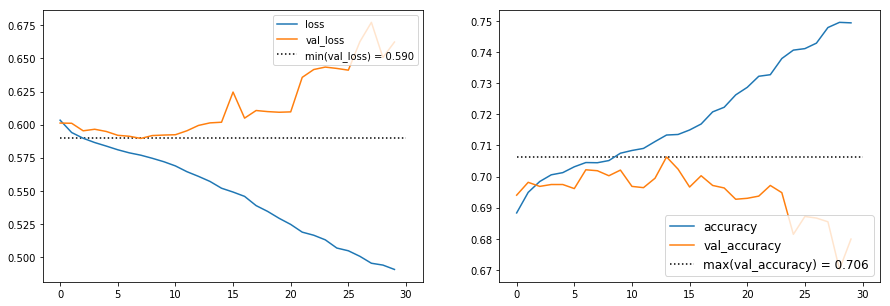

In [22]:
histplot(history)

In [23]:
prediction = []
for i in range(len(x_test_cnn)):
    img = x_test_cnn[i]
    test_image = image.img_to_array(img)
    test_image = np.expand_dims(test_image, axis=0)
    pred = cnnmodel.predict(test_image)
    prediction.append(pred)
prediction = np.array(prediction)

In [24]:
result=[]
for i in range(len(prediction)):
    if np.round(prediction[i]).item(0)==1:
        result.append(0)
    elif np.round(prediction[i]).item(1)==1:
        result.append(1)
    else:
        continue
result = np.array(result)

result_translate = ['Compt', 'Phot']
result_names = []
for i in range(len(result)):
    result_names.append(result_translate[result[i]])
result_names = np.array(result_names)

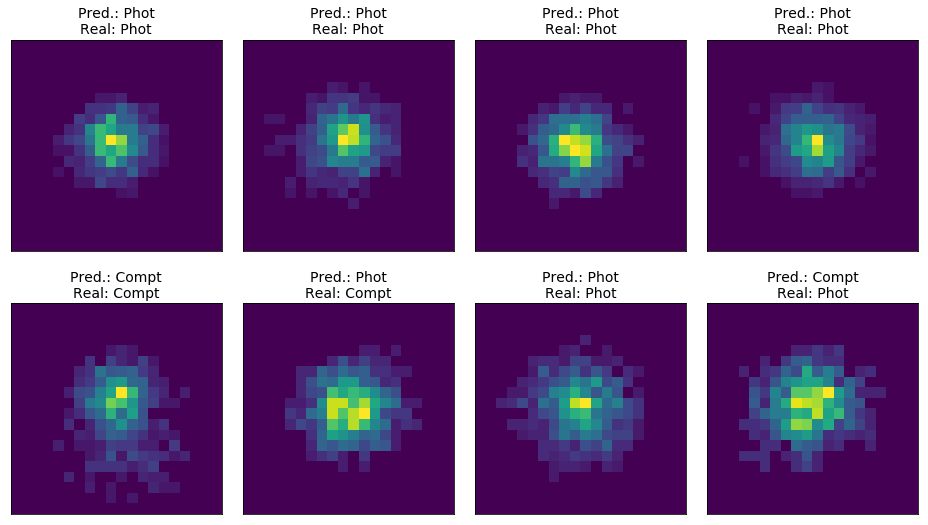

In [25]:
x_test_image = x_test.reshape(len(x_test),20,20)
fig = plt.figure(figsize=(14, 13))
fig.subplots_adjust(left=0, right=0.9, bottom=0, top=1.1, hspace=0.1, wspace=0.1)
for i in range(8):
    ax = fig.add_subplot(4, 4, i+1 , xticks=[], yticks=[])
    ax.imshow(x_test_image[i], interpolation='nearest')
    
    # label the image with the target value
    ax.set_title(F'Pred.: {result_names[i]}'+ '\n' F'Real: {result_translate[int(y_test[i])]}', fontsize=14)
plt.tick_params()

In [30]:
true_results = np.equal(y_test, result)
percentage   = np.round(sum(true_results)/len(y_test)*100, decimals=2)
print('--------------------------------')
print('# CORRECT PREDICTIONS:')
print(f'{sum(true_results)} of total {len(y_test)} ---> {percentage} %')
print('--------------------------------')

--------------------------------
# CORRECT PREDICTIONS:
6796 of total 10000 ---> 67.96 %
--------------------------------


In [31]:
tot_true_phot  = np.sum(y_test==1)/100
tot_true_compt = np.sum(y_test==0)/100
print('True phot  labeled as phot  ---> ', int(np.round(np.sum(result[y_test==1]==1)/tot_true_phot)), '%')
print('True phot  labeled as compt ---> ', int(np.round(np.sum(result[y_test==1]==0)/tot_true_phot)), '%')
print('True compt labeled as compt ---> ', int(np.round(np.sum(result[y_test==0]==0)/tot_true_compt)), '%')
print('True compt labeled as phot  ---> ', int(np.round(np.sum(result[y_test==0]==1)/tot_true_compt)), '%')


True phot  labeled as phot  --->  85 %
True phot  labeled as compt --->  15 %
True compt labeled as compt --->  38 %
True compt labeled as phot  --->  62 %
